In [1]:
# general imports
import sys
sys.path.append("/home/ismini/FastEMRIWaveforms")
print(sys.path)

import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import mpmath

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils import *


['/home/ismini/FastEMRIWaveforms/acer_work', '/home/ismini/anaconda3/envs/few_env/lib/python310.zip', '/home/ismini/anaconda3/envs/few_env/lib/python3.10', '/home/ismini/anaconda3/envs/few_env/lib/python3.10/lib-dynload', '', '/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages', '/home/ismini/FastEMRIWaveforms']


In [2]:
# additional imports
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

from mpmath import *
from scipy.integrate import DOP853
import scipy

# import HaloFeedback (version with additional dLdt evaluation)
#from HaloFeedbackdLdt_ecc import DistributionFunction, PowerLawSpike, PlateauSpike
from Final_HaloFeedback import DistributionFunction, PowerLawSpike

#from fastinterp import *

import time
import warnings
from abc import ABC, abstractmethod
from time import time as timeit

import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import quad, simps
from scipy.interpolate import interp1d
from scipy.special import ellipeinc, ellipkinc, ellipe, ellipk, betainc
from scipy.special import gamma as Gamma
from scipy.special import beta as Beta

import pandas as pd 

In [3]:
# settings for the elliptic integrals
mp.dps = 25
mp.pretty = True

# settings for the waveform
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # 0 (1) we (don't) want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
#from few.utils.utility import omp_set_num_threads
#omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

In [4]:
# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

In [5]:
def Edot_GW(p,e):
    # Azimuthal frequency
    Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

    # Post-Newtonian calculations
    yPN = pow(Omega_phi,2./3.)

    EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
    LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)
    return EdotPN, LdotPN


In [6]:
# this just verifies the elliptic DF losses for e=0 match the circular and the circular without considering any changes in the density

def Edot_DF_circ(p_init, e_init, p, e, M, mu, gamma_evol, rho_sp, r_sp, Lambda=-1):
    p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

    DMS = PowerLawSpike(p_init, e_init, p, e, M, mu, gamma_evol, rho_sp, Lambda=-1)

    r_apo = DMS.r_apo(p, e)
    # rho_apo = DMS.rho(p_pc)
    # rho_apo_init = DMS.rho_init(p_pc)

    Edot_DF_circ = DMS.dEdt_DF(r_apo) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)

    Edot_DF_circ_new = DMS.dEdt_circular(p, e) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)

    # dEdt_DF_ecc_evol feeds with p in pc 
    Edot_DF_ecc = DMS.dEdt_DF_ecc_evol(p_pc, e, gamma_evol, rho_sp, r_sp) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    
    Ldot_DF_ecc = DMS.dLdt_DF_ecc_evol(p_pc, e, gamma_evol, rho_sp, r_sp) * 10**6 /Power(C_SI,2)

    return Edot_DF_circ, Edot_DF_circ_new, Edot_DF_ecc, Ldot_DF_ecc


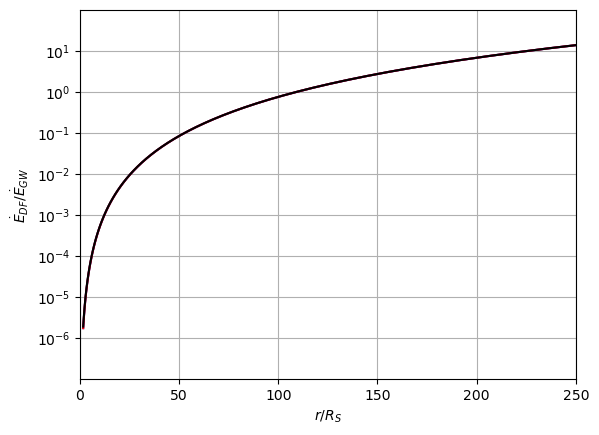

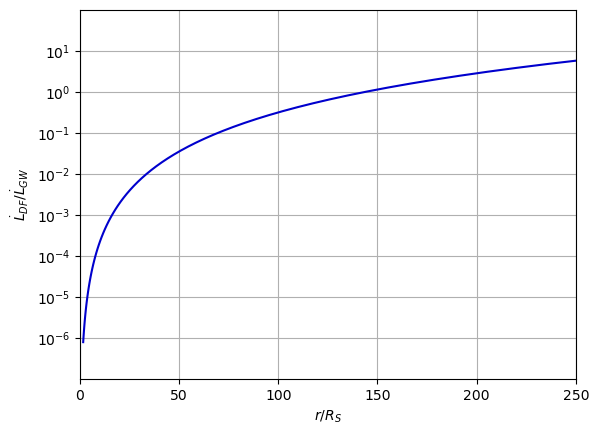

In [7]:
# Testing the losses for eccentric spike vs circular spike without feedback
ptest = 10**np.linspace(1, 4, 100)
M = 1e5 # M_sun
mu = 1e1 # M_sun
rho_sp = 226 # M_sun pc^-3
gamma_sp = 7/3
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc


Edot_circ = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[0]/Edot_GW(pp,0.0)[0] for pp in ptest])
Edot_circ_new = np.asarray([Edot_DF_circ(pp, 0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[1]/Edot_GW(pp, 0.0)[0] for pp in ptest])
Edot_ecc = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[2]/Edot_GW(pp,0.0)[0] for pp in ptest])
Ldot_ecc = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[3]/Edot_GW(pp,0.0)[1] for pp in ptest])

plt.figure()
plt.semilogy(ptest/6, Edot_circ, color = 'mediumblue')
plt.semilogy(ptest/6, Edot_circ_new, color='r')
plt.semilogy(ptest/6, Edot_ecc, color='k')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r/R_S$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-7), 100])
plt.yticks([10**i for i in range(-6, 2)])
plt.show()

plt.figure()
plt.semilogy(ptest/6, Ldot_ecc, color = 'mediumblue')
plt.ylabel('$\dot{L}_{DF}/\dot{L}_{GW}$')
plt.xlabel('$r/R_S$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-7), 100])
plt.yticks([10**i for i in range(-6, 2)])
plt.show()


In [8]:
def spike_evolution(p0, e0, t0, p, e, t, M, mu, rho_sp, r_sp, gamma_init, DMS = None):
    # you can use p,e as variables
    # not sure if (I probably must) I need to use p0, e0 as variables
    # use functions of ecc_rel_HaloFeedback.py as DMS.
    # following EvolutionPlot.py
    # make sure to use functions of ecc_rel_HaloFeedback.py

    # unit conversions
    #G_N = 4.3021937e-3
    pc_to_km = 3.08567758149137e13

    SPEED_CUT = True

    if DMS is None:
        DMS = PowerLawSpike(p0, e0, p, e, M=M, mu=mu, gamma=gamma_init, rho_sp=rho_sp, Lambda=-1)

    #r0_apo = p0_pc/(1 - e0) # initial apocenter in pc
    r0_apo = DMS.r_apo(p0, e0)
    #v0_ecc_apo = np.sqrt((G_N * M)/(p0_pc)) * (1 - e0) # initial velocity of the CO in km/s
    v0_ecc_apo = DMS.v_ecc_apo(p0, e0)

    v_cut = -1 # to use functions of ecc_rel_HaloFeedback
    if SPEED_CUT:
        v_cut = v0_ecc_apo

    #r_apo = p_pc/(1 - e) # apocenter in pc
    r_apo = DMS.r_apo(p, e) # apocenter in pc
    #r_peri = p_pc/(1 + e) # pericenter in pc
    r_peri = DMS.r_peric(p, e) # pericenter in pc
    
    #v_ecc_apo = np.sqrt((G_N * M)/(p_pc)) * (1 - e) # velocity of the CO in km/s
    v_ecc_apo = DMS.v_ecc_apo(p, e)
    v_ecc_peri = DMS.v_ecc_peri(p, e)

    T_orb = 2 * np.pi * r0_apo * pc_to_km / v0_ecc_apo # orbital time in sec
    
    N_orb = int((t - t0)/T_orb) # Number of orbits within (|p_i - p_i+1|, |e_i - e_i+1|) to evolve
    if N_orb >= 10000:
        orbits_per_step = 500
    elif N_orb >= 1000 and N_orb < 10000:
        orbits_per_step = 100
    elif N_orb >= 100 and N_orb < 1000:
        orbits_per_step = 50
    else:
        orbits_per_step = 10
        
    N_step = int(N_orb / orbits_per_step)

    if N_step <= 1:
        N_step = 2 

    # we don't need many steps, EMRI cycles are aprox. 10^4 - 10^5
    # the CO will pass many times from the same radii

    dt = T_orb * orbits_per_step # in sec
    t_list = dt * N_step * np.linspace(0, 1, N_step + 1)

    print('Number of orbits = ', N_orb)
    print('Total time [days] = ', N_step*dt/(3600*24))

    # radial grid for calculating the density
    # check that r0_apo and r_peri are updated for each (p,e)
    # update them in the integrator of the trajectory module, where this function is also going to be used
    N_r = 100 
    r_list = np.linspace(r0_apo, r_peri, N_r - 1)
    r_list = np.sort(np.append(r_list, r_apo))

    rho_list = np.zeros((N_step + 1, N_r))

    # extract the index of r_peri 
    # (that is where we will get the updated density 
    # and feed it to dEdt_DF_ecc) 
    r_apo_ind = np.where(r_list == r_apo)[0][0]

    M_dm_list = np.zeros(N_step-1)
    M_dm_list[0] = DMS.TotalMass()

    # using the proper dEdtDF
    DF_list = np.zeros(N_step)
    DF_list[0] = DMS.dEdt_DF(r0_apo, v_cut)

    E_list = np.zeros(N_step)
    E_list[0] = DMS.TotalEnergy()

    E_ej_tot = 0.0 * t_list

    if SPEED_CUT: 
        rho_init = np.array([DMS.rho(r, v_ecc_apo) for r in r_list])
        
    rho_list[0, :] = rho_init

    for i in range(N_step):
        if SPEED_CUT:
             rho_list[i, :] = np.array([DMS.rho(r, v0_ecc_apo) for r in r_list])

        M_dm_list[i-1] = DMS.TotalMass()

        E_ej_tot[i] = E_ej_tot[i-1] + DMS.dEdt_ej(v_orb=v0_ecc_apo, v_cut=v_cut) * dt

        df1 = DMS.delta_f(r0_apo, v_orb=v0_ecc_apo, dt=dt, v_cut=v_cut)
        DMS.f_eps += df1
        df2 = DMS.delta_f(r0_apo, v_orb=v0_ecc_apo, dt=dt, v_cut=v_cut)
        DMS.f_eps += 0.5 * (df2 - df1)

        E_list[i] = DMS.TotalEnergy()

        DF_list[i] = DMS.dEdt_DF(r0_apo, v_cut)

    r_apo = r_list[r_apo_ind]
    rho_apo_init = rho_list[0, r_apo_ind]
    rho_apo_evol = rho_list[-2, r_apo_ind]

    gamma_evol = np.log(rho_apo_evol/rho_apo_init) / np.log(r_sp/r_apo) + gamma_init

    return gamma_evol

In [9]:
def dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp):
        """Rate of change of energy due to DF (km/s)^2 s^-1 M_sun.
        Use to find the energy losses from one set of (p,e, gamma) to the next.

        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
            - r_sp: constant normalization radius [pc]
        """
        pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s

        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dEdt = (1 / pc_to_km) * (2*(1 - e**2)**(3/2) * G_N**(3/2) * 0.58 * mu**2 * rho_sp * r_sp**(gamma) * CoulombLog)/(np.sqrt(M) * p_pc**(gamma -1/2))

        def integrand_E(theta):

            return dEdt * (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)
    
        result_E, error_E = quad(integrand_E, 0.0, 2 * np.pi)
        E_dot_DF = result_E * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    
        return (E_dot_DF)


def dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp):
        """Rate of change of angular momentum in [(km/s)^2 M_sun].
        Use to find the angular momentum losses from one set of (p,e, gamma) to the next.
    
        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
            - r_sp: constant normalization radius [pc]
        """
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s

        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dLdt = (2 * (1 - e**2)**(3/2) * G_N * mu**2 * rho_sp * r_sp**(gamma) * CoulombLog)/(M* p_pc**(gamma -2))

        def integrand_L(theta):

            return dLdt * (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / (1 + 2 * e * np.cos(theta) + e**2)**(3/2)
    
        result_L, error_L = quad(integrand_L, 0.0, 2 * np.pi)
        L_dot_DF = result_L * 10**6 /Power(C_SI,2)

        return (L_dot_DF)


### This is the actual trajectory class that can be used to produce GWs of EMRIs embedded in dynamic spikes.

In [10]:
# trying to plot the energy and angular momentum losses from the trajectory 
# maybe different in the sense that it cannot be used to produce waveforms.
# maybe put an if before the return of DFTrajectory to select if you wanna use for GWs or not.
# as in first use for the spike, get plots and then use for GWs
# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class DF:
    def __init__(self, epsilon, M, mu, rho_sp, r_sp):
        self.epsilon = epsilon
        self.M = M
        self.mu = mu
        self.rho_sp = rho_sp
        self.r_sp = r_sp

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon
        M = self.M
        mu = self.mu
        rho_sp = self.rho_sp
        r_sp = self.r_sp
        
        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y
        gamma = self.gamma_evol

        # guard against bad integration steps
        if e >= 1.0 or p < 6.0 or (p - 6 - 2* e) < 0.05:
#             print('bad', y)
            return [0.0, 0.0, 0.0, 0.0]
        if e<1e-5:
            e = 1e-5

        # Azimuthal frequency
        # perform elliptic calculations
        Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

        # GW
        EdotPN, LdotPN = Edot_GW(p,e)

        # dynamical friction parameters
        EdotDF = dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp)
        LdotDF = dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp)

        # flux
        Edot = -epsilon*(EdotPN + EdotDF)
        Ldot = -epsilon*(LdotPN + LdotDF)
        
        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = Omega_r;
        
        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]
            
        if e<=1e-5:
            dydt[1] = 0.0

        return dydt


# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class DFTrajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, *args, T=1.0, dt=10.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        Msec = M * MTSUN_SI

        epsilon = mu/M

        M = M
        mu = mu
        rho_sp = args[1]
        r_sp = args[2]
        p_init = p0
        e_init = e0
        t_init = 0
        gamma_init = args[0]


        rhs = DF(epsilon, M, mu, rho_sp, r_sp)
        rhs.gamma_evol = gamma_init

        # the tolerance is important!
        integrator = DOP853(rhs, 0.0, y0, T, rtol=1e-12, atol=1e-12, first_step=dt/Msec)


        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:

            integrator.step()
            
            p, e, Phi_phi, Phi_r = integrator.y

            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            t = integrator.t * Msec
            gamma_evol = spike_evolution(p_init, e_init, t_init, p, e, t, M, mu, rho_sp, r_sp, gamma_init, DMS=None)
            # print(t - t_init)
            p_init = p
            e_init = e
            t_init = t
            gamma_init = gamma_evol

            if (p - 6 -2*e) < 0.05:
                run = False


        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        print(p_out)
 
        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    

traj = DFTrajectory()

p0[pc] =  1.7196507147966344e-07
Number of orbits =  0
Total time [days] =  0.15429862416974358
Number of orbits =  0
Total time [days] =  0.15429862037045902
Number of orbits =  0
Total time [days] =  0.15429859859815917
Number of orbits =  1
Total time [days] =  0.15429850507157203
Number of orbits =  2
Total time [days] =  0.1542982491033923
Number of orbits =  7
Total time [days] =  0.15429756955655846
Number of orbits =  22
Total time [days] =  0.15429556288094262
Number of orbits =  70
Total time [days] =  0.5400144704163234
Number of orbits =  314
Total time [days] =  2.314081372393817
Number of orbits =  2225
Total time [days] =  16.961177439601897
Number of orbits =  15514
Total time [days] =  119.06090203758983
Number of orbits =  19998
Total time [days] =  145.8559422282083
Number of orbits =  21188
Total time [days] =  151.4698948812457
Number of orbits =  21220
Total time [days] =  145.34985412589302
Number of orbits =  20686
Total time [days] =  135.7102804501009
Number o

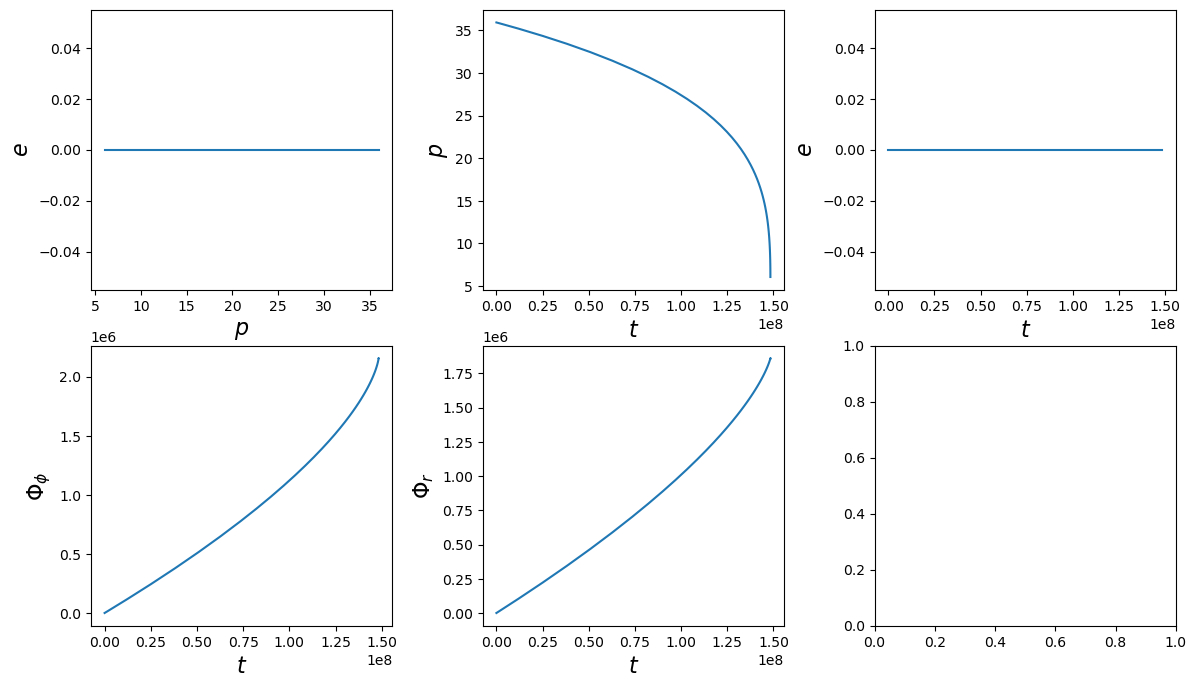

In [11]:
# testing the trajectory
M = 1e5 # M_sun
mu = 1e1 # M_sun
p0 = 35.93515813204665
p0_in_pc = (p0*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
print('p0[pc] = ', p0_in_pc)
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

dynamic_spike_traj = traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, r_sp, T=T, dt=10.0)
t_s, p_s, e_s, x_s, Phi_phi_s, Phi_theta_s, Phi_r_s = dynamic_spike_traj
# spline the results
spline_s = CubicSplineInterpolant(t_s, np.stack((p_s, e_s, x_s, Phi_phi_s, Phi_theta_s, Phi_r_s)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_s, p_s, e_s, Phi_phi_s, Phi_r_s]
xs = [p_s, t_s, t_s, t_s, t_s]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Number of orbits =  0
Total time [days] =  0.15429862416974358
Number of orbits =  0
Total time [days] =  0.15429862037061656
Number of orbits =  0
Total time [days] =  0.15429860744882307
Number of orbits =  0
Total time [days] =  0.1542985669320636
Number of orbits =  1
Total time [days] =  0.15429846194454522
Number of orbits =  2
Total time [days] =  0.15429818955965502
Number of orbits =  6
Total time [days] =  0.154297529045594
Number of orbits =  18
Total time [days] =  0.15429596592498004
Number of orbits =  55
Total time [days] =  0.38572795087184164
Number of orbits =  227
Total time [days] =  1.5427718356135085
Number of orbits =  1297
Total time [days] =  9.253167456672191
Number of orbits =  11657
Total time [days] =  88.48684304373519
Number of orbits =  19200
Total time [days] =  143.33843111093026
Number of orbits =  21015
Total time [days] =  153.08677807148607
Number of orbits =  21283
Total time [days] =  147.06867954363963
Number of orbits =  20874
Total time [days]

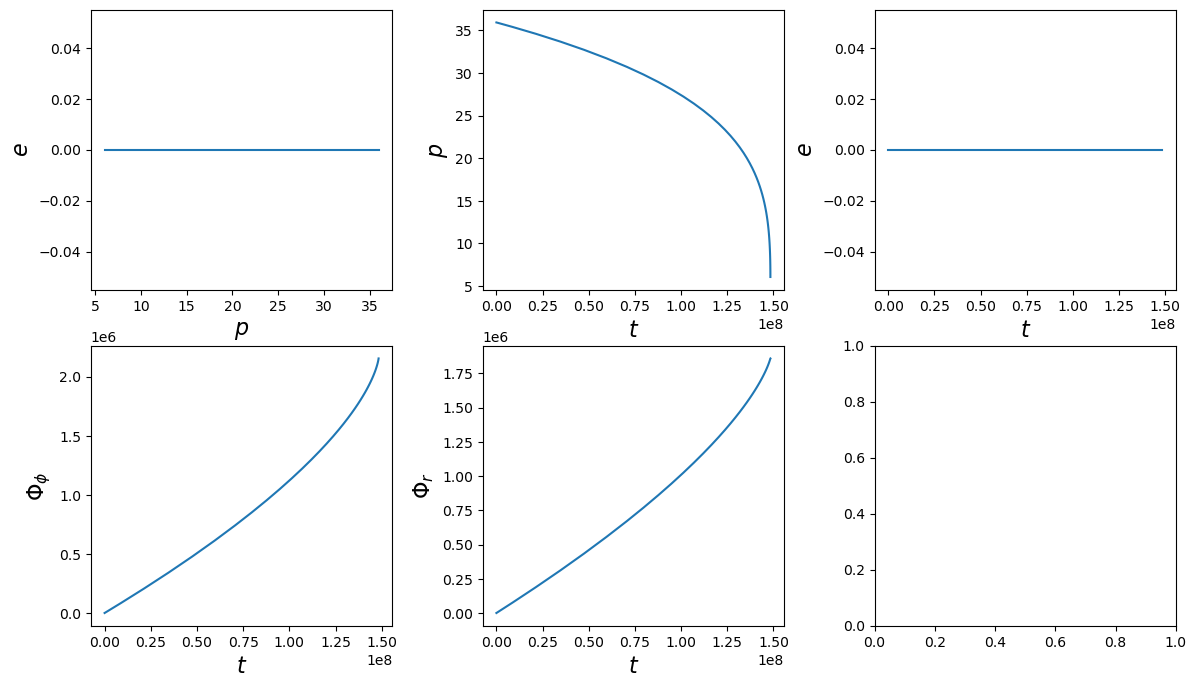

In [13]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

no_spike_traj = traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, r_sp, T=T, dt=10.0)
t, p, e, x, Phi_phi, Phi_theta, Phi_r = no_spike_traj
# spline the results
spline = CubicSplineInterpolant(t, np.stack((p, e, x, Phi_phi, Phi_theta, Phi_r)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_r]
xs = [p, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'p')

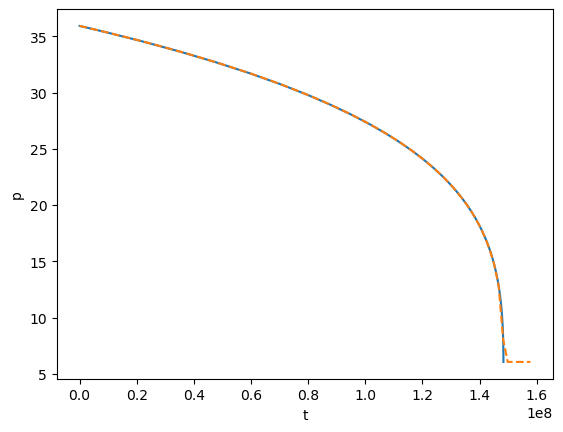

In [14]:
plt.plot(t, p)
newt = np.linspace(0.0, T*YRSID_SI,num=100)

plt.plot(newt, spline(newt)[0],'--')
plt.xlabel('t')
plt.ylabel('p')

Text(0, 0.5, 'Number of cucles')

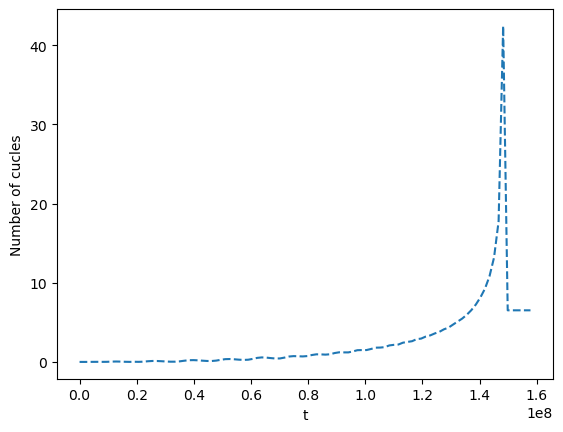

In [15]:
plt.figure()
# the time is store in the spline
plt.plot(newt, np.abs(spline(newt)[3]-spline_s(newt)[3])/(2*np.pi),'--')
plt.xlabel('t')
plt.ylabel('Number of cucles')
# should be fig 5 https://arxiv.org/pdf/2211.01362.pdf

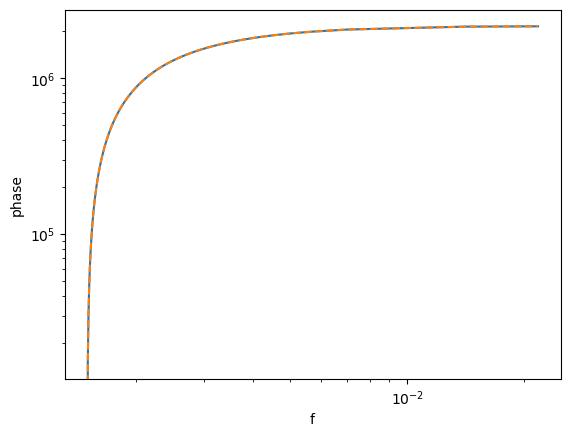

/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages/few/summation/interpolatedmodesum.py:217: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  warnings.warn(


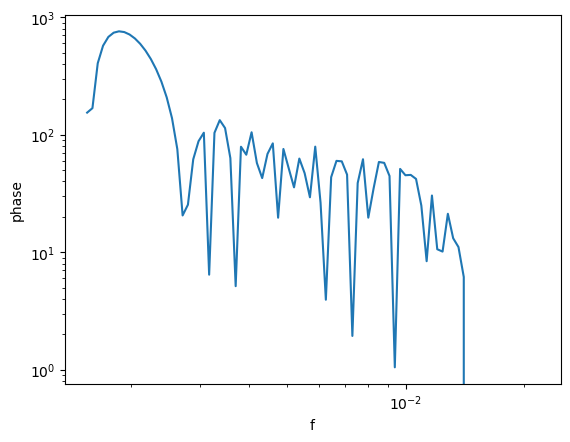

In [16]:
# omega = p**(-3/2)
# no spike
ff = spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase = spline(newt)[3]
spl_phase = CubicSplineInterpolant(ff, phase)
# spike
ff_sp = spline_s(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase_sp = spline_s(newt)[3]
spl_phase_sp = CubicSplineInterpolant(ff_sp, phase_sp)

freq = 10**np.linspace(-3,np.log10(np.max(ff)),num=100)

plt.figure()
# the time is store in the spline
plt.loglog(ff, phase)
plt.loglog(ff_sp, phase_sp,'--')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('f')
plt.ylabel('phase')
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(spl_phase(freq)-spl_phase_sp(freq)) )
plt.xlabel('f')
plt.ylabel('phase')
plt.show()

In [ ]:
M = 1e5
mu = 1e1
#p0 = 20
p0 = 35.93515813204665
e0 = 0.3
theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc
rho_sp = 220
gamma_sp = 7.0/3
T = 5.0
dt = 10.0

traj = EMRIInspiral(func="SchwarzEccFlux")
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=5.0)


from few.amplitude.romannet import RomanAmplitude
amp = RomanAmplitude(max_init_len=5000)
teuk_modes = amp(p, e)
plt.figure()
plt.plot(p**(-3/2), teuk_modes[:, amp.special_index_map[(2,2,0)]].real, label='Re A')
plt.plot(p**(-3/2), teuk_modes[:, amp.special_index_map[(2,2,0)]].imag, label='Im A')
plt.ylabel('A')
plt.xlabel('p')
plt.legend()
plt.show()

In [ ]:
class ApproxSchwarzschildEccentricFluxDF(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            DFTrajectory, # here it is the new trajectory!
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

In [ ]:
test = ApproxSchwarzschildEccentricFluxDF()

M = 1e5
mu = 1e1
p0 = 16
#p0 = 35.93515813204665
e0 = 0.3
theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc
rho_sp = 220
gamma_sp = 7.0/3
T = 5.0
dt = 10.0

specific_modes = (2,2,0)

# waveform with spike
wave1 = test(M, mu, p0, e0, theta, phi, rho_sp, gamma_sp, dist=dist, dt=dt, T=T)
time1 = np.arange(0, len(wave1))*dt

rho_sp = 0.01
gamma_sp = 1.1

# waveform without spike
wave2 = test(M, mu, p0, e0, theta, phi, rho_sp, gamma_sp, dist=dist, dt=dt, T=T)
time2 = np.arange(0, len(wave2))*dt

plt.plot(time1, wave1.real, label='spike')
plt.plot(time2, wave2.real, 'r--', label='no spike')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()

In [ ]:
overlap = get_overlap(wave1, wave2)
print('O = ' ,overlap)

mismatch = get_mismatch(wave1, wave2)
print('M = ', mismatch)